In [1]:
%load_ext autoreload
%autoreload 2
import os
os.chdir('/home/svcl-oowl/brandon/research/CVPR_2021_REFINE/sil_consistent_at_inference')
print(os.getcwd())

/home/svcl-oowl/brandon/research/CVPR_2021_REFINE/sil_consistent_at_inference


In [2]:
import pprint
import glob
from pathlib import Path
import pickle
import random

import torch
from PIL import Image
import numpy as np
from pytorch3d.renderer import look_at_view_transform, TexturesVertex
import matplotlib.pyplot as plt
import trimesh
from tqdm.autonotebook import tqdm
from pytorch3d.io import save_obj
import pandas as pd
from pytorch3d.structures import Pointclouds
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVOrthographicCameras, 
    PointsRasterizationSettings,
    PointsRenderer,
    PointsRasterizer,
    AlphaCompositor,
    OpenGLPerspectiveCameras, 
    NormWeightedCompositor
)

from utils import general_utils, visualization_tools, eval_utils
from evaluation import compute_iou_2d, compute_iou_2d_given_pose, compute_iou_3d, compute_chamfer_L1, sample_points
from utils.brute_force_pose_est import brute_force_estimate_pose, brute_force_estimate_dist
from mesh_refiner import MeshRefiner

In [3]:
# shapenet
dataset_type = "shapenet"
class_name = "03001627"
gt_shapes_list_path = "data/gt_shapes_path_lists/shapenet_{}_gt_shapes.lst".format(class_name)

# regular ---
input_img_dir = "data/input_images/pytorch3d_shapenet_renders/{}/rgba".format(class_name)
# atlasnet
#input_mesh_dir = "/home/svcl-oowl/brandon/research/CVPR_2021_REFINE/AtlasNet/data/pytorch_3d_render_recs/{}".format(class_name)
# pix2mesh
#input_mesh_dir = "/home/svcl-oowl/brandon/research/CVPR_2021_REFINE/Pixel2Mesh/rec_files/pytorch3d_shapenet_renders/{}/rgba".format(class_name)
# occnet
input_mesh_dir = "/home/svcl-oowl/brandon/research/CVPR_2021_REFINE/occupancy_networks/out/pytorch3d_renders/{}/generation/meshes".format(class_name)

# asym ---
#input_img_dir = "data/input_images/asym_pytorch3d_shapenet_renders/{}/rgba".format(class_name)
#input_mesh_dir = "/home/svcl-oowl/brandon/research/occupancy_networks/out/asym_pytorch3d_renders/{}/generation/meshes".format(class_name)


# pix3d
#dataset_type = "pix3d"
#class_name = "chair"
#input_mesh_dir = "/home/svcl-oowl/brandon/research/occupancy_networks/out/pix3d/{}/generation/meshes".format(class_name)
#input_img_dir = "data/input_images/pix3d_images_processed_filtered/{}/rgba".format(class_name)
#gt_shapes_list_path = "data/gt_shapes_path_lists/pix3d_{}_gt_shapes.lst".format(class_name)

# hole test
#input_img_dir = "data/test/hole_cube/img"
#input_mesh_dir = "data/test/hole_cube/mesh"
#gt_shapes_list_path = None

In [8]:
cfg_dicts = {"cfg_01": "configs/sim_pipeline_01.yaml"}
#cfg_dicts = {"cfg_00": "configs/sim_pipeline_00.yaml", "cfg_01": "configs/sim_pipeline_01.yaml", "cfg_02": "configs/sim_pipeline_02.yaml", "cfg_03": "configs/sim_pipeline_03.yaml"}
#cfg_dicts = {"cfg_01": "configs/sim_pipeline_01.yaml", "cfg_02": "configs/sim_pipeline_02.yaml", "cfg_03": "configs/sim_pipeline_03.yaml", "cfg_04": "configs/sim_pipeline_04.yaml"}
for cfg_name in cfg_dicts:
    cfg_dicts[cfg_name] = general_utils.load_config(cfg_dicts[cfg_name], "configs/default.yaml")

# If show_metrics is true, gt_shapes_list_path needs to be specified
show_metrics = False
device = torch.device("cuda:0")
pose_dict = pickle.load(open(os.path.join(input_img_dir, "renders_camera_params.pt"), "rb"))

instances = [str(path).split('/')[-1].replace(".obj", "") for path in list(Path(input_mesh_dir).rglob("*.obj"))]
instances = random.sample(instances, 3)
# airplane
#instances = ["ed35478403ae873943cf31d2bcc8f4", "ed2aaca045fb1714cd4229f38ad0d015", "e9b29777e840e1fb63737f7c5d9fc39b", "de7cc3442b1775d46559a92f80e3672e", "d5e01850a9d1f3ac5fb48d488d5dfafd"]
# chair 
instances = ["d30e58a2361785683fb0851e9bc87551", "cc25ba35b3f6e8d3d064b65ccd89778c", "d4326cd55ed8333f6a059e1fc701f06", "d02f9ae175fa83d3e6fe3612af521500", "d1291956cb0983ee7085b4353236aad",
            "ee4858f78dc33591100e9bd5c4b0af54", "e0efbc4e240b9cc235836c728d324152", "d6ac690c293a492d2d2a5d4c4022b4c6", "d20de927fd1b15ef104c86562c321749",
            "e7d4a3cca8edfde4829113e62386fd50", "d97a4a6f84f40854f51fa0238791f5dc", "ce9cedc58c77aab4b5a19b1840ec7af"]
# table
#instances = ["cf5e67d5e6d7cf03f26f8ea67fbd8269", "d6ef0aa7b674c171fb4f26e87f6a6814", "d46537f513283d6cdcfcef693e7ec696", "d7792a9c16aaf16d98e0d1738edd4f19", "dfef8f26e9a8437782db9fca4b68095"]

print(instances)

['d30e58a2361785683fb0851e9bc87551', 'cc25ba35b3f6e8d3d064b65ccd89778c', 'd4326cd55ed8333f6a059e1fc701f06', 'd02f9ae175fa83d3e6fe3612af521500', 'd1291956cb0983ee7085b4353236aad', 'ee4858f78dc33591100e9bd5c4b0af54', 'e0efbc4e240b9cc235836c728d324152', 'd6ac690c293a492d2d2a5d4c4022b4c6', 'd20de927fd1b15ef104c86562c321749', 'e7d4a3cca8edfde4829113e62386fd50', 'd97a4a6f84f40854f51fa0238791f5dc', 'ce9cedc58c77aab4b5a19b1840ec7af']


███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████
/home/svcl-oowl/brandon/research/CVPR_2021_REFINE/occupancy_networks/out/pytorch3d_renders/03001627/generation/meshes/d30e58a2361785683fb0851e9bc87551.obj
███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████
cfg_01 -- With sil, both pretrained, 0 dis weight
first rel


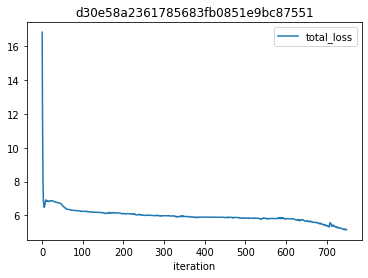

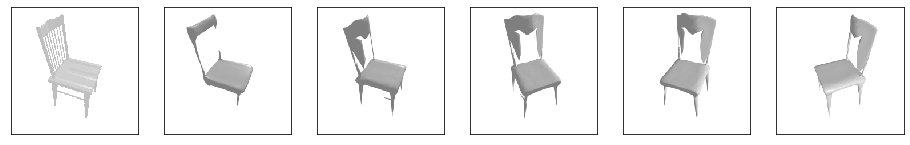

███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████
/home/svcl-oowl/brandon/research/CVPR_2021_REFINE/occupancy_networks/out/pytorch3d_renders/03001627/generation/meshes/cc25ba35b3f6e8d3d064b65ccd89778c.obj
███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████
cfg_01 -- With sil, both pretrained, 0 dis weight
first rel


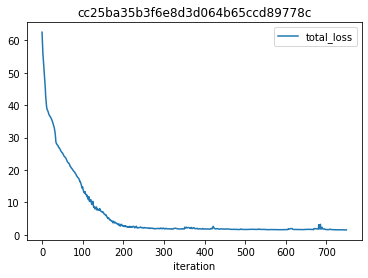

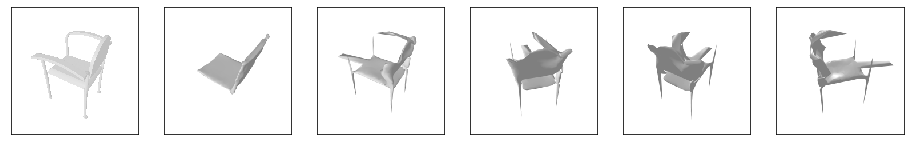

███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████
/home/svcl-oowl/brandon/research/CVPR_2021_REFINE/occupancy_networks/out/pytorch3d_renders/03001627/generation/meshes/d4326cd55ed8333f6a059e1fc701f06.obj
███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████
cfg_01 -- With sil, both pretrained, 0 dis weight
first rel


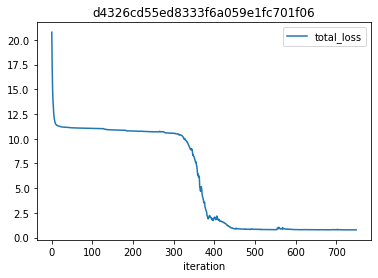

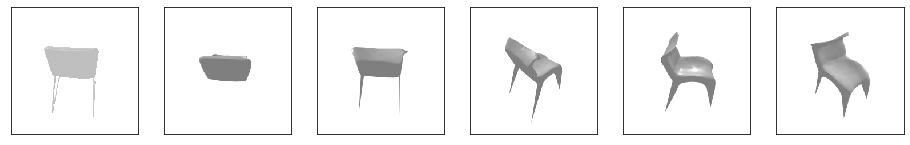

███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████
/home/svcl-oowl/brandon/research/CVPR_2021_REFINE/occupancy_networks/out/pytorch3d_renders/03001627/generation/meshes/d02f9ae175fa83d3e6fe3612af521500.obj
███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████
cfg_01 -- With sil, both pretrained, 0 dis weight
first rel


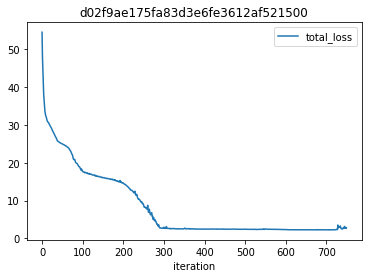

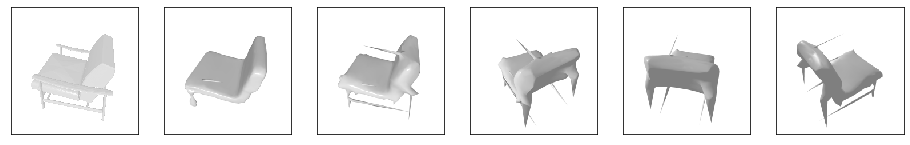

███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████
/home/svcl-oowl/brandon/research/CVPR_2021_REFINE/occupancy_networks/out/pytorch3d_renders/03001627/generation/meshes/d1291956cb0983ee7085b4353236aad.obj
███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████
cfg_01 -- With sil, both pretrained, 0 dis weight
first rel


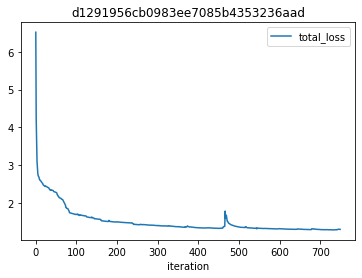

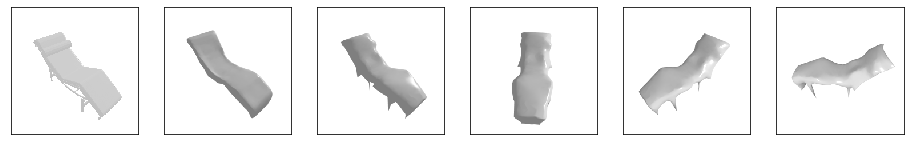

███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████
/home/svcl-oowl/brandon/research/CVPR_2021_REFINE/occupancy_networks/out/pytorch3d_renders/03001627/generation/meshes/ee4858f78dc33591100e9bd5c4b0af54.obj
███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████
cfg_01 -- With sil, both pretrained, 0 dis weight
first rel


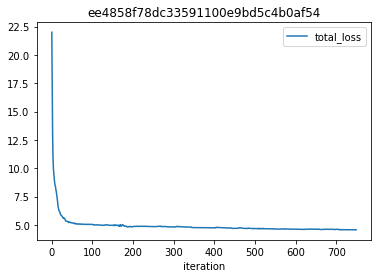

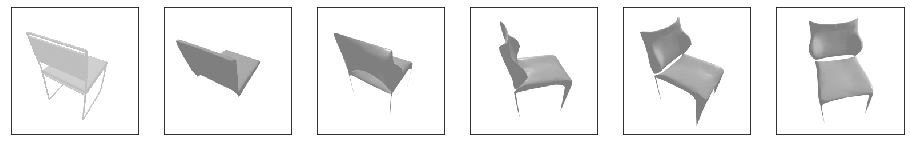

███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████
/home/svcl-oowl/brandon/research/CVPR_2021_REFINE/occupancy_networks/out/pytorch3d_renders/03001627/generation/meshes/e0efbc4e240b9cc235836c728d324152.obj
███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████
cfg_01 -- With sil, both pretrained, 0 dis weight
first rel


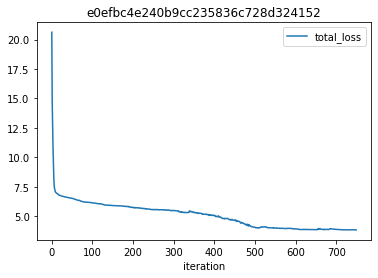

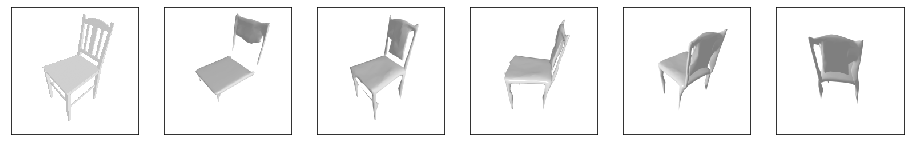

███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████
/home/svcl-oowl/brandon/research/CVPR_2021_REFINE/occupancy_networks/out/pytorch3d_renders/03001627/generation/meshes/d6ac690c293a492d2d2a5d4c4022b4c6.obj
███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████
cfg_01 -- With sil, both pretrained, 0 dis weight
first rel


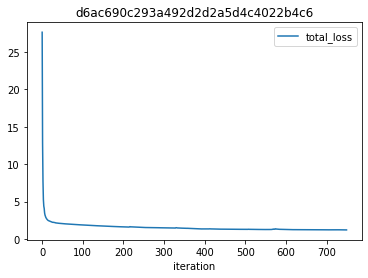

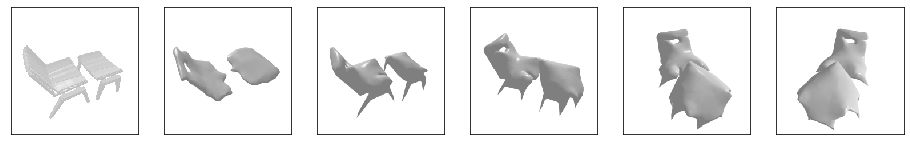

███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████
/home/svcl-oowl/brandon/research/CVPR_2021_REFINE/occupancy_networks/out/pytorch3d_renders/03001627/generation/meshes/d20de927fd1b15ef104c86562c321749.obj
███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████
cfg_01 -- With sil, both pretrained, 0 dis weight
first rel


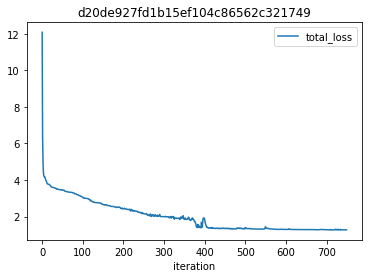

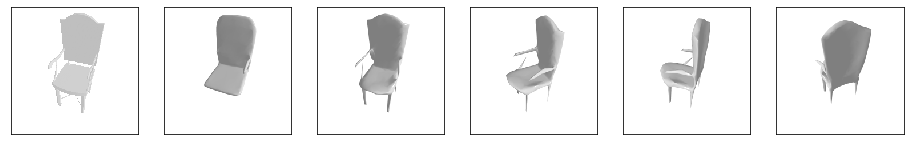

███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████
/home/svcl-oowl/brandon/research/CVPR_2021_REFINE/occupancy_networks/out/pytorch3d_renders/03001627/generation/meshes/e7d4a3cca8edfde4829113e62386fd50.obj
███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████
cfg_01 -- With sil, both pretrained, 0 dis weight
first rel


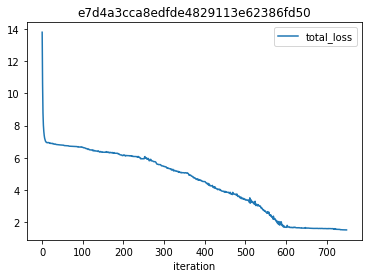

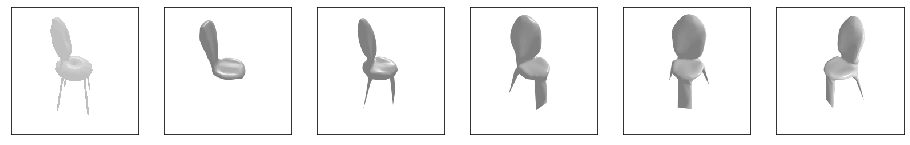

███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████
/home/svcl-oowl/brandon/research/CVPR_2021_REFINE/occupancy_networks/out/pytorch3d_renders/03001627/generation/meshes/d97a4a6f84f40854f51fa0238791f5dc.obj
███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████
cfg_01 -- With sil, both pretrained, 0 dis weight
first rel


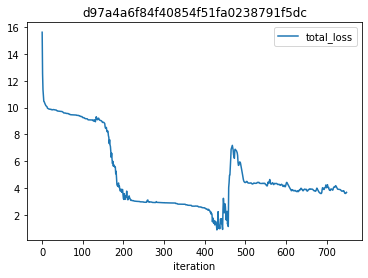

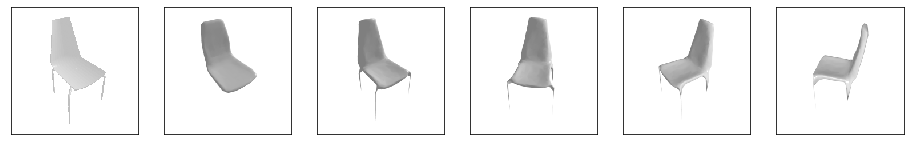

███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████
/home/svcl-oowl/brandon/research/CVPR_2021_REFINE/occupancy_networks/out/pytorch3d_renders/03001627/generation/meshes/ce9cedc58c77aab4b5a19b1840ec7af.obj
███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████
cfg_01 -- With sil, both pretrained, 0 dis weight
first rel


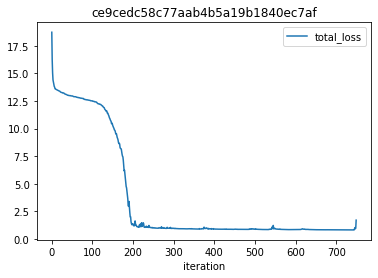

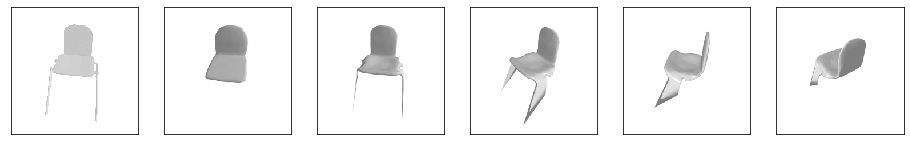

In [9]:
if gt_shapes_list_path is not None:
    gt_shapes_dict = {}
    with open(gt_shapes_list_path, 'r') as f:
        f = f.read().split('\n')
        for line in f:
            if line != "":
                gt_shapes_dict[line.split(" ")[0]] = line.split(" ")[1]


pose_settings=["gt"]

results_df = pd.DataFrame()
all_refinement_info = {}
for instance in instances:
    input_img_path = os.path.join(input_img_dir,"{}.png".format(instance))
    input_image = np.asarray(Image.open(input_img_path))
    input_mesh_path = os.path.join(input_mesh_dir,"{}.obj".format(instance))
    print("███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████")
    print(input_mesh_path)
    print("███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████")
    with torch.no_grad():
        input_mesh = general_utils.load_untextured_mesh(input_mesh_path, device)
    input_trimesh= trimesh.load(input_mesh_path)
    mask = np.asarray(input_image)[:,:,3] > 0
    
    if gt_shapes_list_path is not None:
        gt_mesh_path = gt_shapes_dict[instance.split("_")[0]]
        with torch.no_grad():
            gt_mesh = general_utils.load_untextured_mesh(gt_mesh_path, device)
        gt_trimesh = trimesh.load(gt_mesh_path)
    
    instance_info = {"instance": instance}
    pose_info_list = []
    num_dists=40
    if "gt" in pose_settings:
        gt_elev = pose_dict[instance]["elev"]
        gt_azim = pose_dict[instance]["azim"]
        #gt_dist = pose_dict[instance]["dist"]
        _, _, gt_dist, _, _ = brute_force_estimate_dist(input_mesh, mask, gt_azim, gt_elev, num_dists, device)
        pose_info_list.append([gt_dist.item(), gt_elev, gt_azim, "gt"])
    if "bf" in pose_settings:
        num_azims=20
        num_elevs=20
        bf_pred_azim, bf_pred_elev, bf_pred_dist, _, _ = brute_force_estimate_pose(input_mesh, mask, num_azims, num_elevs, num_dists, device)
        pose_info_list.append([bf_pred_dist.item(), bf_pred_elev.item(), bf_pred_azim.item(), "bf"])
        
    for (dist, elev, azim, name) in pose_info_list:
        #if dataset_type == "pix3d":
        #    azim = azim - 90
        #dist = float(dist)
        #elev = float(elev)
        #azim = float(azim)
        #print(dist, elev, azim, name)
        if show_metrics:
            input_metrics_dict, input_debug_dict = eval_utils.eval_metrics(input_image, input_trimesh, input_mesh, gt_trimesh, 
                                                                           gt_mesh, device, metrics_to_eval=["2d_iou_multi", "2d_iou_input", "3d_iou", "chamfer_L1"],
                                                                           pred_azim=azim, pred_elev=elev, pred_dist=dist)
            instance_info = {**instance_info, **{"original_{}_{}".format(name, metric):input_metrics_dict[metric] for metric in input_metrics_dict}}
            print("Input mesh metrics: {}".format(input_metrics_dict))
        
        for cfg_name in cfg_dicts:
            print("======================================================================================================================")
            print("{} -- {}".format(cfg_name, cfg_dicts[cfg_name]["description"]))
            print("======================================================================================================================")
            mesh_refiner = MeshRefiner(cfg_dicts[cfg_name], device)
            refined_mesh, refinement_info = mesh_refiner.refine_mesh(input_mesh, input_image, dist, elev, azim, record_debug=True)
            refinement_info["refined_mesh"] = refined_mesh.detach().cpu()
            all_refinement_info[instance] = refinement_info
            refined_mesh_path = os.path.join("notebooks/out", "{}_{}_{}.obj".format(instance, name, cfg_name))
            save_obj(refined_mesh_path, refined_mesh.verts_packed(), refined_mesh.faces_packed())
            refined_trimesh = trimesh.load(refined_mesh_path)
            refined_mesh = general_utils.load_untextured_mesh(refined_mesh_path, device)
            if show_metrics:
                refined_metrics_dict, refined_debug_dict = eval_utils.eval_metrics(input_image, refined_trimesh, refined_mesh, gt_trimesh, gt_mesh, device, 
                                                                              metrics_to_eval=["2d_iou_multi", "2d_iou_input", "3d_iou", "chamfer_L1"],
                                                                              pred_azim=azim, pred_elev=elev, pred_dist=dist)
                print("Refined mesh metrics: {}".format(refined_metrics_dict))
                instance_info = {**instance_info, **{"refined_{}_{}".format(name, metric):refined_metrics_dict[metric] for metric in refined_metrics_dict}}
            refinement_info["loss_info"].plot.line(x='iteration', y='total_loss', title="{}".format(instance))
            visualization_tools.show_refinement_results(input_image, input_mesh, refined_mesh, dist, elev, azim, device)
    
    results_df = results_df.append(instance_info, ignore_index=True)


In [8]:
# converts conf_scores in [0,1] to rgb from red to green.
# input is a (num_verts, 1) numpy array
def sym_conf_to_rgb(sym_conf_scores, lower=0.0, upper=1.0):
    sym_conf_scores_normalized = (sym_conf_scores-np.min(sym_conf_scores))/(np.max(sym_conf_scores)-np.min(sym_conf_scores))
    #sym_conf_scores_normalized = sym_conf_scores
    rgb_conf_scores = []
    for conf_score in sym_conf_scores_normalized[:,0]:
        if conf_score < (lower+upper)/2:
            rgb_conf_scores.append([1,max(conf_score*3+0.2, conf_score*2),0])
        else:
            rgb_conf_scores.append([(1-conf_score)*2,1,0])
    return np.array(rgb_conf_scores)

def sym_conf_to_bw(sym_conf_scores):
    sym_conf_scores_normalized = (sym_conf_scores-np.min(sym_conf_scores))/(np.max(sym_conf_scores)-np.min(sym_conf_scores))
    rgb_conf_scores = []
    for conf_score in sym_conf_scores_normalized[:,0]:
        rgb_conf_scores.append([conf_score, conf_score, conf_score])
    return np.array(rgb_conf_scores)

def render_and_show(mesh, device, dist=1.3, elev=35, azim=25):
    R, T = look_at_view_transform(dist, elev, azim) 
    render = general_utils.render_mesh(mesh, R, T, device)
    plt.imshow(render[0, ..., :3].detach().cpu().numpy())
    plt.show()
    
def render_pointcloud(verts_padded, verts_rgb, dist, elev, azim, device):

    # make pointcloud 
    point_cloud = Pointclouds(points=verts_padded, features=verts_rgb).to(device)

    # get render
    raster_settings = PointsRasterizationSettings(image_size=512, radius = 0.008,points_per_pixel = 10)
    R, T = look_at_view_transform(dist, elev, azim) 
    cameras = OpenGLPerspectiveCameras(device=device, R=R, T=T)
    rasterizer = PointsRasterizer(cameras=cameras, raster_settings=raster_settings)
    renderer = PointsRenderer(rasterizer=rasterizer,compositor=AlphaCompositor(background_color=(1, 1, 1,0)))
    
    # show render
    images = renderer(point_cloud)
    plt.figure(figsize=(10, 10))
    plt.imshow(images[0, ..., :3].cpu().numpy())
    plt.grid("off")
    plt.axis("off")
    plt.show()
    
    

9e998a06601e9f944b2bd73664dd1844
[[0.383888  ]
 [0.38577008]
 [0.39828944]
 ...
 [0.907575  ]
 [0.9103162 ]
 [0.9358467 ]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


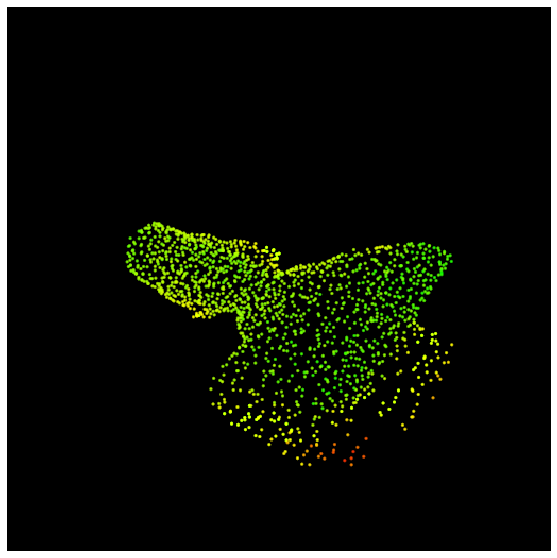

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


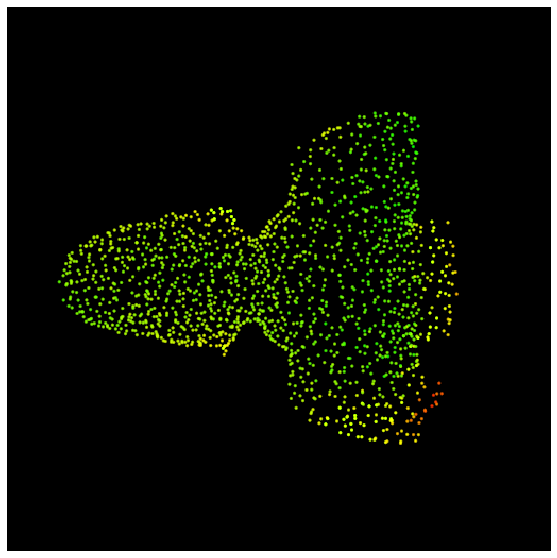

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


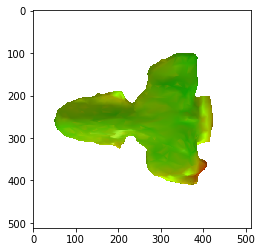

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


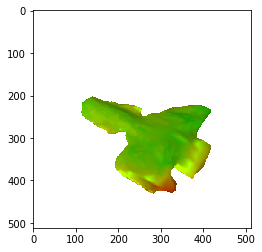

In [9]:
show_scatter = True
show_texture = True
for instance in all_refinement_info:
    print("=============================================================================================")
    print(instance)
    sym_conf_scores = all_refinement_info[instance]["asym_conf_scores"]
    print(np.sort(sym_conf_scores.numpy(), axis=0))
    
    refined_mesh = all_refinement_info[instance]["refined_mesh"]
    mesh_verts = refined_mesh.verts_packed()
    mesh_rgb_verts = sym_conf_to_rgb(sym_conf_scores.numpy())
    mesh_rgb_vergs_features = torch.tensor(mesh_rgb_verts, dtype=torch.float32).unsqueeze(0).to(device)
    
    # show scatterplot of vertices
    render_pointcloud(refined_mesh.verts_padded(), mesh_rgb_vergs_features, dist, elev, azim, device)
    render_pointcloud(refined_mesh.verts_padded(), mesh_rgb_vergs_features, 1.2, 90, 0, device)
    
    # show barycentric interploated vertex texture map
    if show_texture:
        refined_mesh = all_refinement_info[instance]["refined_mesh"].to(device)
        refined_mesh.textures = TexturesVertex(verts_features = mesh_rgb_vergs_features)
        render_and_show(refined_mesh, device, dist=1.2, elev=90, azim=0)
        render_and_show(refined_mesh, device, dist=dist, elev=elev, azim=azim)
    

In [17]:
print(dist, elev, azim, name)

1.3333332538604736 19.239840215987783 309.79291849283413 gt


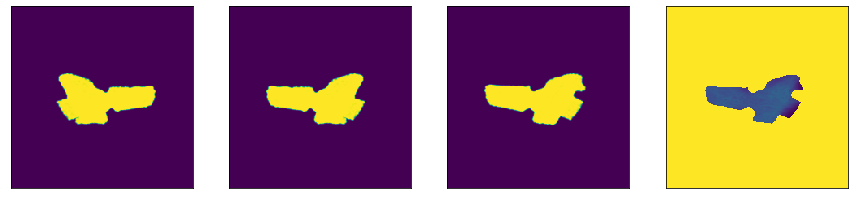

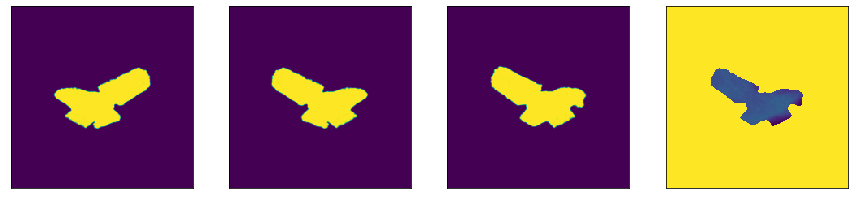

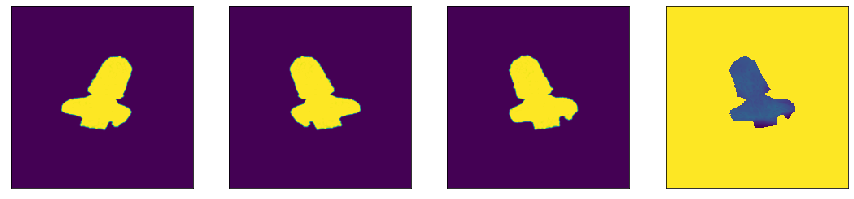

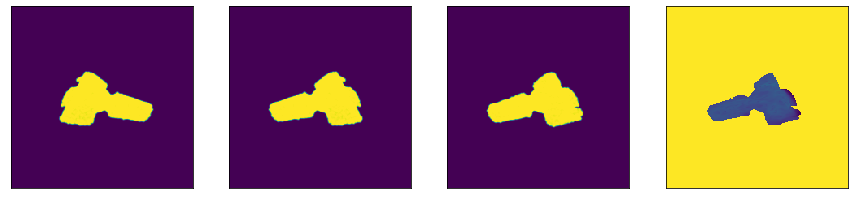

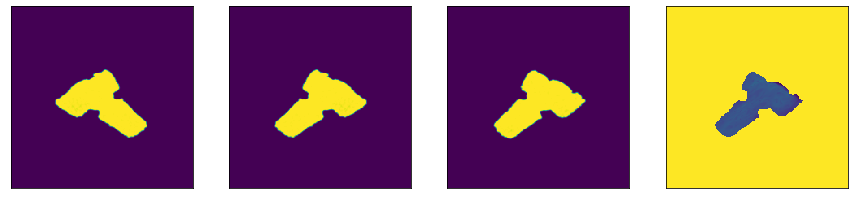

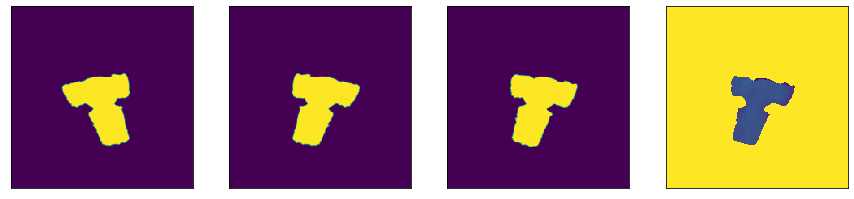

In [9]:
sil = True
for sym_quad in refinement_info["img_sym_loss_debug_imgs"][0]:
    fig, ax = plt.subplots(nrows=1, ncols=4, squeeze=False, figsize=(15,10))
    for i, render in enumerate(sym_quad):
        if sil:
            ax[0][i].imshow(render.detach().cpu().numpy())
        else:
            ax[0][i].imshow(render[..., 0].detach().cpu().numpy())
        ax[0][i].xaxis.set_visible(False)
        ax[0][i].yaxis.set_visible(False)
    plt.show()
    
    

# Legacy

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

num_verts = refinement_info["sym_conf_scores"].shape[0]
mesh_verts = refined_mesh.verts_packed()
for i in range(num_verts):
    x = mesh_verts[i][0].item()
    y = mesh_verts[i][1].item()
    z = mesh_verts[i][2].item()
    sym_conf = sym_conf_scores_normalized[i][0]
    color = np.array([[sym_conf,0,0]])
    ax.scatter(x, y, z, c=color, marker='.')

plt.show()

In [ ]:
    #if show_scatter:
    #    fig = plt.figure()
    #    ax = fig.add_subplot(111)
    #    num_verts = sym_conf_scores.shape[0]
    #    for i in range(num_verts):
    #        x = mesh_verts[i][0].item()
    #        y = mesh_verts[i][1].item()
    #        z = mesh_verts[i][2].item()
    #        color = np.expand_dims(mesh_rgb_verts[i], 0)
    #        ax.scatter(x, z, c=color, marker='.')
    #    plt.show()